In [3]:
%matplotlib inline

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii, fits
import astropy.constants as const

c = const.c.cgs.value

## Some functions

In [5]:
def CircularAperture(x, y, r, pix=10000.):
    
    grid_x, grid_y = np.meshgrid(np.linspace(0,pix-1,pix), np.linspace(0,pix-1,pix))
    grid_x = grid_x - (pix-1)/2.
    grid_y = grid_y - (pix-1)/2.
    grid_dist = ((grid_x-x)**2+(grid_y-y)**2)**0.5
    aperture = np.where(grid_dist <= r, np.full((pix, pix), 1, dtype=int), 0)
    
    return aperture

In [6]:
def Total_MaskedAperture(aperture, mask):
    
    aperture_masked = np.where(mask != 0, aperture, 0)
    
    return aperture_masked, np.sum(aperture_masked)

In [7]:
def Mask(x, y, radius, pix=10000.):
    
    init_arr = np.full((pix, pix), 1, dtype=int)
    grid_x, grid_y = np.meshgrid(np.linspace(0,pix-1,pix), np.linspace(0,pix-1,pix))
    
    dist_x = grid_x - (pix-1)/2. - x
    dist_y = grid_y - (pix-1)/2. - y
    
    aper_trim = np.where((dist_x**2+dist_y**2)**0.5 <= radius, init_arr, 0)
    
    return aper_trim

## SPIRE beam profiles

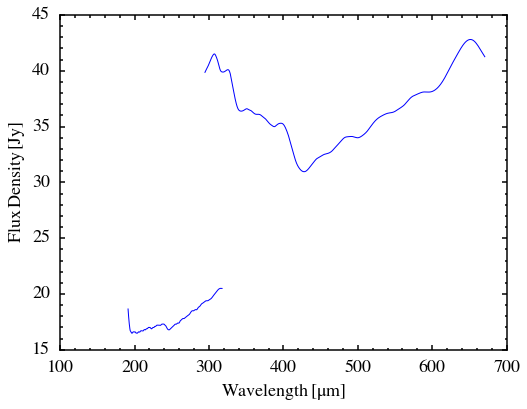

In [8]:
# read in the SSW beam profile
wl_ssw_beam, diam_ssw_beam = np.genfromtxt('/Users/yaolun/test/SSW_beam_profile.txt').T

# read in the SLW beam profile
wl_slw_beam, diam_slw_beam = np.genfromtxt('/Users/yaolun/test/SLW_beam_profile.txt').T

# plot beam profiles
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

ax.plot(wl_ssw_beam, diam_ssw_beam, 'b-')
ax.plot(wl_slw_beam, diam_slw_beam, 'b-')

ax.set_xlim([100, 700])
ax.set_xlabel(r'$\rm{Wavelength\,[\mu m]}$', fontsize=18)
ax.set_ylabel(r'$\rm{Flux\,Density\,[Jy]}$', fontsize=18)
[ax.spines[axis].set_linewidth(1.5) for axis in ['top','bottom','left','right']]
ax.minorticks_on()
ax.tick_params('both',labelsize=18,width=1.5,which='major',pad=10,length=5)
ax.tick_params('both',labelsize=18,width=1.5,which='minor',pad=10,length=2.5)

# SPIRE FITS

In [9]:
hdu = fits.open('/Users/yaolun/bhr71/calibration_testing/HSA/bhr71_spire_point_apod.fits')

## Weights for SSW

In [ ]:
%%time
# do 200" x 200"
pix = 5000.
factor = pix/200.
aper_rad = 15.9
weight_ssw = np.empty((len(range(9,26)), len(diam_ssw_beam)))
aperture = CircularAperture(0, 0, aper_rad*factor, pix=pix)
ideal = (diam_ssw_beam*factor/2.)**2*np.pi

a = np.full((pix, pix), 0)

# center of SSW module
cen_ra = hdu[18].header['RA']
cen_dec = hdu[18].header['DEC']

# SSW
s = 0
for i in range(9,26):
    ra = (hdu[i].header['RA']-cen_ra)*np.cos(np.radians(cen_dec))*3600.
    dec = (hdu[i].header['DEC']-cen_dec) * 3600.
    
    # check if the pixel has any overlap with the aperture to save some computing time
    if (ra**2+dec**2) > aper_rad+max(diam_ssw_beam):
        weight_ssw[i-9,:].fill(0)
        continue

    for iw in range(len(diam_ssw_beam)):
#     for iw in range(0,20):
        masked_arr, arr_sum = Total_MaskedAperture(aperture,
                                    Mask(ra*factor, dec*factor, diam_ssw_beam[iw]*factor/2., pix=pix))
        if (arr_sum/ideal[iw]) >= 0.99:
            weight_ssw[i-9,iw] = 1
        else:
            weight_ssw[i-9,iw] = arr_sum/ideal[iw]
            s += 1

In [ ]:
print arr_sum, ideal[19], np.sum(aperture)

In [ ]:
plt.imshow(weight_ssw, extent=[0,6,0,6])

In [ ]:
import cProfile
cProfile.run('Total_MaskedAperture(aperture,Mask(0, 0, 250., pix=5000.))')

In [ ]:
# create empty arrays and apply the weighting
wl_ssw_wsum = c/1e5/hdu[18].data.field(0)
flux_ssw_wsum = np.zeros_like(wl_ssw_wsum)

for iw in range(len(wl_ssw_wsum)):
    for i in range(9,26):
        flux_dum = hdu[i].data.field(1)
        flux_ssw_wsum[iw] += flux_dum[iw] * weight_ssw[i-9,iw]

# sort the spectrum with the increase of wavelength
sorter = np.argsort(wl_ssw_wsum)
wl_ssw_wsum = wl_ssw_wsum[sorter]
flux_ssw_wsum = flux_ssw_wsum[sorter]

# trim the spectrum like SPIRE-1D spectra in CDF archive
flux_ssw_wsum = flux_ssw_wsum[(wl_ssw_wsum >= 195.) & (wl_ssw_wsum < 310.)]
wl_ssw_wsum = wl_ssw_wsum[(wl_ssw_wsum >= 195.) & (wl_ssw_wsum < 310.)]

# write the summed spectrum into ASCII file
foo = open('/Users/yaolun/bhr71/calibration_testing/bhr71_ssw_tophat_weighted_sum.txt','w')
for wave in wl_ssw_wsum:
    foo.write('{} \t {}\n'.format(wave, flux_ssw_wsum[wl_ssw_wsum == wave][0]))
foo.close()

# save the SSW weight array
np.save('/Users/yaolun/bhr71/calibration_testing/bhr71_ssw_tophat_weight', weight_ssw)

## Weights for SLW

In [12]:
%%time
# do 200" x 200"
pix = 5000.
factor = pix/200.
aper_rad = 15.9
weight_slw = np.empty((len(range(9,26)), len(diam_slw_beam)))
aperture = CircularAperture(0, 0, aper_rad*factor, pix=pix)
ideal = (diam_slw_beam*factor/2.)**2*np.pi

a = np.full((pix, pix), 0)

# center of SLW module
cen_ra = hdu[5].header['RA']
cen_dec = hdu[5].header['DEC']

# SSW
for i in range(2,9):
    ra = (hdu[i].header['RA']-cen_ra)*np.cos(np.radians(cen_dec))*3600.
    dec = (hdu[i].header['DEC']-cen_dec) * 3600.
    
    # check if the pixel has any overlap with the aperture to save some computing time
    if (ra**2+dec**2)**0.5 > aper_rad+max(diam_slw_beam):
        weight_slw[i-2,:].fill(0)
        continue

#     for iw in range(len(diam_slw_beam)):
    for iw in range(10):
        masked_arr, arr_sum = Total_MaskedAperture(aperture,
                                    Mask(ra*factor, dec*factor, diam_slw_beam[iw]*factor/2., pix=pix))
        if (arr_sum/ideal[iw]) >= 0.99:
            weight_slw[i-2,iw] = 1
        else:
            weight_slw[i-2,iw] = arr_sum/ideal[iw]

CPU times: user 50.4 s, sys: 57.4 s, total: 1min 47s
Wall time: 1min 48s


41.261793 1905


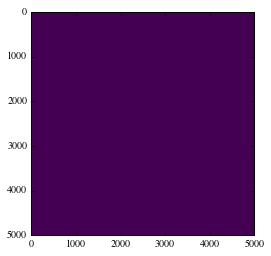

In [13]:
print diam_slw_beam[0], len(diam_slw_beam)
plt.imshow(a, cmap='viridis')

In [ ]:
weight_slw_copy = weight_slw

In [ ]:
# create empty arrays and apply the weighting
wl_slw_wsum = c/1e5/hdu[5].data.field(0)
flux_slw_wsum = np.zeros_like(wl_slw_wsum)

for iw in range(len(wl_slw_wsum)):
    for i in range(2,9):
        flux_dum = hdu[i].data.field(1)
        flux_slw_wsum[iw] += flux_dum[iw] * weight_slw[i-2,iw]
        
# sort the spectrum with the increase of wavelength
sorter = np.argsort(wl_slw_wsum)
wl_slw_wsum = wl_slw_wsum[sorter]
flux_slw_wsum = flux_slw_wsum[sorter]

# trim the spectrum like SPIRE-1D spectra in CDF archive
flux_slw_wsum = flux_slw_wsum[wl_slw_wsum >= 310.]
wl_slw_wsum = wl_slw_wsum[wl_slw_wsum >= 310.]

# write the summed spectrum into ASCII file
foo = open('/Users/yaolun/bhr71/calibration_testing/bhr71_slw_tophat_weighted_sum.txt','w')
for wave in wl_slw_wsum:
    foo.write('{} \t {}\n'.format(wave, flux_slw_wsum[wl_slw_wsum == wave][0]))
foo.close()
# save the SLW weight array
np.save('/Users/yaolun/bhr71/calibration_testing/bhr71_slw_tophat_weight', weight_slw)

In [ ]:
plt.imshow(a+aperture, cmap='viridis')

In [ ]:
# SLW
slw_area = 0
slw_cen_area = Gaussian_anywhere(grid, 0, 0, avg_slw)
for j in range(2,10):
    ra_dum = (hdu[j].header['RA']-cen_ra)*np.cos(np.radians(cen_dec))*3600.
    dec_dum = (hdu[j].header['DEC']-cen_dec) * 3600.
    slw_area += Gaussian_anywhere(grid, ra_dum, dec_dum, avg_slw)

print ssw_cen_area, slw_cen_area
print ssw_area, slw_area, ssw_area/slw_area